In [7]:
import sklearn.preprocessing as prepro
import pandas as pd

In [8]:
data = pd.read_csv("../src/data.csv")
print(data.columns)
print("\n##################################\n")
print(data.dtypes)

Index(['country', 'child_mortality', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expectation', 'total_fertility', 'GDP'],
      dtype='object')

##################################

country              object
child_mortality     float64
exports             float64
health              float64
imports             float64
income                int64
inflation           float64
life_expectation    float64
total_fertility     float64
GDP                 float64
dtype: object


In [11]:
print(pd.isna(data).sum())

country             0
child_mortality     0
exports             0
health              0
imports             0
income              0
inflation           0
life_expectation    0
total_fertility     2
GDP                 2
dtype: int64


In [19]:
print(data_1.head())

               country  child_mortality  exports  health  imports  income  \
0          Afghanistan             90.2     10.0    7.58     44.9    1610   
1              Albania             16.6     28.0    6.55     48.6    9930   
2              Algeria             27.3     38.4    4.17     31.4   12900   
3               Angola            119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda             10.3     45.5    6.03     58.9   19100   

   inflation  life_expectation  total_fertility      GDP  
0       9.44              56.2             5.82    553.0  
1       4.49              76.3             1.65   4090.0  
2      16.10              76.5             2.89   4460.0  
3      22.40              60.1             6.16   3530.0  
4       1.44              76.8             2.13  12200.0  


In [12]:
data_1 = data.fillna(data.mean())
print(pd.isna(data_1).sum())

country             0
child_mortality     0
exports             0
health              0
imports             0
income              0
inflation           0
life_expectation    0
total_fertility     0
GDP                 0
dtype: int64


In [14]:
print(data_1.describe())

       child_mortality     exports      health     imports         income  \
count       167.000000  167.000000  167.000000  167.000000     167.000000   
mean         38.270060   41.108976    6.815689   46.890215   17144.688623   
std          40.328931   27.412010    2.746837   24.209589   19278.067698   
min           2.600000    0.109000    1.810000    0.065900     609.000000   
25%           8.250000   23.800000    4.920000   30.200000    3355.000000   
50%          19.300000   35.000000    6.320000   43.300000    9960.000000   
75%          62.100000   51.350000    8.600000   58.750000   22800.000000   
max         208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expectation  total_fertility             GDP  
count  167.000000        167.000000        167.00000      167.000000  
mean     7.781832         70.134132          2.92600    29710.387879  
std     10.570704         10.435428          1.47034   132688.767896  
min     -4.210000     

AxesSubplot(0.125,0.125;0.775x0.755)


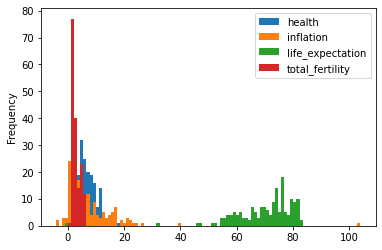

In [30]:
for column in data.columns:
    print()